In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import torch
from torch.utils.data import DataLoader

import sys

sys.path.append("../electric-properties-only")
sys.path.append("../end-to-end")
sys.path.append("../end-to-end-with-feedback")
sys.path.append("../../efish-physics-model/objects")
sys.path.append("../../efish-physics-model/helper_functions")
sys.path.append("../../efish-physics-model/uniform_points_generation")

# from helpers_conv_nn_models import make_true_vs_predicted_figure
from electric_images_dataset import ElectricImagesDataset
from EndToEndConvNN_PL import EndToEndConvNN_PL
from EndToEndConvNNWithFeedback_PL import EndToEndConvNNWithFeedback_PL
from ElectricPropertiesNN_PL import ElectricPropertiesNN_PL

## Load trained Models

In [3]:
models = pd.DataFrame()

#### Prepare dataset for dummy run to initialize LazyLayers

In [4]:
batch_size = 1000
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
original_dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)
original_stats = pd.DataFrame.from_dict(original_dset.worms_properties_stats)[
    ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
]
data_dir_name = "../../efish-physics-model/data/processed/data-2025_01_08-detection_noise_threshold"
# data_dir_name = "../../efish-physics-model/data/processed/data-2024_12_11-discrimination_dataset"
raw_dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)
new_stats = pd.DataFrame.from_dict(dset.worms_properties_stats)[
    ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
]
dset.worms_properties_stats = original_dset.worms_properties_stats
dset.worms_properties = (
    dset.worms_properties[:] * new_stats.loc["std"].to_numpy()
    + new_stats.loc["mean"].to_numpy()
    - original_stats.loc["mean"].to_numpy()
) / original_stats.loc["std"].to_numpy()
dloader = DataLoader(dset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=12)

scale_data_dir_name = "../../efish-physics-model/data/processed/data-2024_12_20-discrimination_dataset-retrain_scale_rule"
raw_scale_dataset = pd.read_pickle(f"{scale_data_dir_name}/dataset.pkl")
scale_dset = ElectricImagesDataset(data_dir_name=scale_data_dir_name, fish_t=20, fish_u=30)

#### Load full end-to-end models

In [5]:
for folder in list(np.sort(glob.glob("../figures/stats-panel/full-model*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNN_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame({"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "full", "model": [model]}),
        ]
    ).reset_index(drop=True)

/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
# load the retrained scale model
# checkpoint_path = f"../electric-properties-only/retrain_scale/lightning_logs/version_4/checkpoints/epoch=599-step=21000.ckpt"
checkpoint_path = f"../electric-properties-only/retrain_scale/lightning_logs/version_6/checkpoints/epoch=999-step=35000.ckpt"
retrained_scale_model = ElectricPropertiesNN_PL.load_from_checkpoint(checkpoint_path)
retrained_scale_model.eval()
retrained_scale_model.freeze()
retrained_scale_model.cpu()

ElectricPropertiesNN_PL(
  (model): ElectricPropertiesNN(
    (sequence): Sequential(
      (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=2, out_features=10, bias=True)
      (2): ReLU()
      (3): Linear(in_features=10, out_features=20, bias=True)
      (4): ReLU()
      (5): Linear(in_features=20, out_features=10, bias=True)
      (6): ReLU()
      (7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [7]:
for i, folder in enumerate(list(np.sort(glob.glob("../figures/stats-panel/feedback-with-values*")))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    model.model.spatial_model = models.loc[i, "model"].model
    # model.model.spatial_model.linear.fc3.linear.weight = torch.nn.Parameter(models.loc[i, "model"].model.linear.fc3.linear.weight[:4].clone())
    model.model.feedback_model = retrained_scale_model.model
    
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame(
                {"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "feedback_vals", "model": [model]}
            ),
        ]
    ).reset_index(drop=True)

for i, folder in enumerate(list(np.sort(glob.glob("../figures/stats-panel/feedback-with-estimates*")))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    model.model.spatial_model = models.loc[i, "model"].model
    # model.model.spatial_model.linear.fc3.linear.weight = torch.nn.Parameter(models.loc[i, "model"].model.linear.fc3.linear.weight[:4].clone())
    model.model.feedback_model = retrained_scale_model.model
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame(
                {"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "feedback_esti", "model": [model]}
            ),
        ]
    ).reset_index(drop=True)

In [8]:
models = models[models["lambda_RC"] > 0].reset_index(drop=True)
# models = models[models["model_type"]=="full"].reset_index(drop=True)
models = models[models["model_type"]!="feedback_vals"].reset_index(drop=True)

In [9]:
models

,rand_seed,lambda_RC,model_type,model
0,11,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
1,11,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
2,11,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
3,11,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
4,11,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
5,113,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
6,113,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
7,113,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
8,113,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
9,113,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...


## Inspect discrimination data

In [10]:
eis = next(iter(dloader))[0]
distance_ids = raw_dataset["worms"]["dataframe"]["position_ys"]
max_mod = eis[:, :, 5, 6]
print(eis.shape, max_mod.shape)

torch.Size([168, 2, 20, 30]) torch.Size([168, 2])


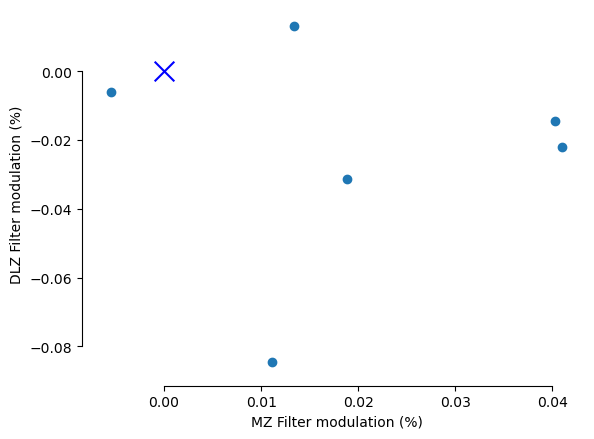

In [11]:
mask = raw_dataset["worms"]["dataframe"]["position_ys"] == 27
mask &= raw_dataset["worms"]["dataframe"]["radii"] == 0
plt.scatter(*eis[mask, :, 5, 6].T)
plt.scatter([0], [0], c="b", marker="x", s=200)
plt.xlabel("MZ Filter modulation (%)")
plt.ylabel("DLZ Filter modulation (%)")
sns.despine(offset=5, trim=True)
plt.show()

### Create discrimination training and testing data

In [26]:
n_repeats = 100
noise_amount = 0.1

train_mask = distance_ids % 4 < 2
train_eis = torch.tile(eis[train_mask], (n_repeats, 1, 1, 1))
train_distance_ids = torch.tile(torch.tensor(distance_ids[train_mask].to_numpy()), (n_repeats,))
train_labels = torch.ones(train_eis.shape[0])
train_eis = torch.vstack([train_eis, torch.zeros_like(train_eis)])
train_distance_ids = torch.hstack([train_distance_ids, -torch.ones_like(train_distance_ids)])
train_labels = torch.hstack([train_labels, torch.zeros_like(train_labels)])
train_eis = train_eis + torch.randn_like(train_eis) * noise_amount

valid_eis = torch.tile(eis, (n_repeats, 1, 1, 1))
valid_distance_ids = torch.tile(torch.tensor(distance_ids.to_numpy()), (n_repeats,))
valid_labels = torch.ones(valid_eis.shape[0])
valid_eis = torch.vstack([valid_eis, torch.zeros_like(valid_eis)])
valid_distance_ids = torch.hstack([valid_distance_ids, -torch.ones_like(valid_distance_ids)])
valid_labels = torch.hstack([valid_labels, torch.zeros_like(valid_labels)])
valid_eis = valid_eis + torch.randn_like(valid_eis) * noise_amount

## Compute models predictions

In [32]:
models["prediction_train"] = models.apply(
    lambda x: (x["model"].model(train_eis).detach().cpu().numpy()),
    axis=1,
)
models["prediction_valid"] = models.apply(
    lambda x: (x["model"].model(valid_eis).detach().cpu().numpy()),
    axis=1,
)

# models["prediction_train"] = models.apply(
#     lambda x: (
#         x["model"].model(train_eis, train_props[:, 1], train_props[:, 3]).detach().cpu().numpy()
#         if x["model_type"] == "feedback_vals"
#         else x["model"].model(train_eis).detach().cpu().numpy()
#     ),
#     axis=1,
# )
# models["prediction_valid"] = models.apply(
#     lambda x: (
#         x["model"].model(valid_eis, valid_props[:, 1], valid_props[:, 3]).detach().cpu().numpy()
#         if x["model_type"] == "feedback_vals"
#         else x["model"].model(valid_eis).detach().cpu().numpy()
#     ),
#     axis=1,
# )

In [52]:
def train_detection(dfrow):
    shuffle_perm = np.random.permutation(len(train_eis))
    # train_x = dfrow["prediction_train"][shuffle_perm]
    # train_x = train_eis.reshape(len(train_eis), -1)[shuffle_perm]
    train_x = train_eis[:, :, 5, 6].reshape(-1, 2)[shuffle_perm]
    train_y = train_labels[shuffle_perm]
    rfc = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", n_jobs=-1)
    rfc.fit(train_x, train_y)
    train_preds = rfc.predict(train_x)
    # valid_x = dfrow["prediction_valid"]
    # valid_x = valid_eis.reshape(len(valid_eis), -1)
    valid_x = valid_eis[:, :, 5, 6].reshape(-1, 2)
    valid_y = valid_labels
    valid_preds = rfc.predict(valid_x)

    train_df = pd.DataFrame(dict(true_y=train_y, pred_y=train_preds, dist_ids=train_distance_ids[shuffle_perm]))
    valid_df = pd.DataFrame(dict(true_y=valid_y, pred_y=valid_preds, dist_ids=valid_distance_ids))

    dfrow["train_accuracy"] = train_df.groupby("dist_ids").apply(lambda x: (x["true_y"] == x["pred_y"]).mean() * 100)
    dfrow["valid_accuracy"] = valid_df.groupby("dist_ids").apply(lambda x: (x["true_y"] == x["pred_y"]).mean() * 100)
    return dfrow

In [53]:
models = models.apply(train_detection, axis=1)

In [54]:
models.head()

,rand_seed,lambda_RC,model_type,model,prediction_train,prediction_valid,train_accuracy,valid_accuracy
0,11,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[0.7486106, -1.3995911, -0.007150134, -0.7499...","[[1.040018, -1.5614218, 0.18859912, -0.5825211...",dist_ids -1 95.785714 0 100.000000 ...,dist_ids -1 92.291667 0 100.000000 ...
1,11,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.3487506, -1.5163516, -0.25362504, -0.27606...","[[1.362275, -1.3700353, -0.7417816, -0.1671537...",dist_ids -1 95.833333 0 100.000000 ...,dist_ids -1 92.452381 0 100.000000 ...
2,11,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[0.97183263, -1.4161577, 0.038025036, -1.0954...","[[0.93818676, -1.3051424, 0.0028720647, -1.033...",dist_ids -1 95.940476 0 100.000000 ...,dist_ids -1 92.505952 0 100.000000 ...
3,11,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[0.9818261, -1.3654938, 0.15281333, -0.748562...","[[0.90716314, -1.3230798, 0.29882824, -0.71638...",dist_ids -1 95.714286 0 100.000000 ...,dist_ids -1 92.523810 0 100.000000 ...
4,11,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[0.9934491, -1.4196432, 0.06581679, -0.878162...","[[0.9151686, -1.289576, 0.03995623, -0.9394347...",dist_ids -1 96.011905 0 100.000000 ...,dist_ids -1 92.470238 0 100.000000 ...


## Plot psychometric curve

In [50]:
def plot_psychometric_curves(dfrow):
    distances = (
        raw_dataset["worms"]["position_ys"]
        - raw_dataset["worms"]["radii"]
        - raw_dataset["fish"]["dataframe"]["objs"].iloc[0].get_lateral_semi_axis()
    )
    clr = "C0" if dfrow["model_type"] == "full" else "C1"
    for data_type in ["train", "valid"]:
        ls = "-" if data_type == "train" else "--"
        curve = dfrow[f"{data_type}_accuracy"]
        # plt.scatter(x=0, y=curve[-1], label=data_type, c=clr)
        no_obj = curve[-1]
        curve = curve[curve.index != -1]
        plt.plot(distances[curve.index]*1e3, (curve + no_obj)/2, lw=1, c=clr, ls=ls)
    pass

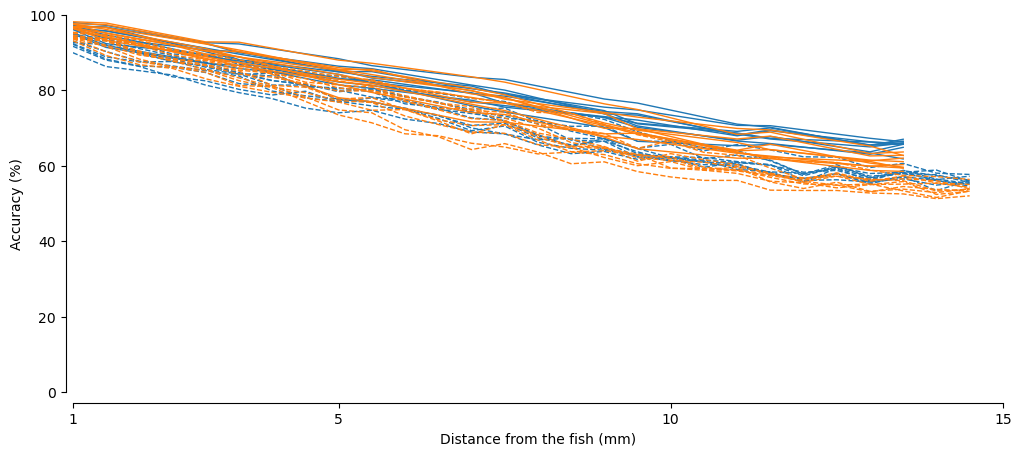

In [40]:
plt.figure(figsize=(12,5))
models.apply(plot_psychometric_curves, axis=1)
plt.ylim(-1,101)
plt.xlim(1,15)
plt.xticks([1, 5, 10, 15])
sns.despine(offset=5, trim=True)
plt.xlabel("Distance from the fish (mm)")
plt.ylabel("Accuracy (%)")
plt.show()

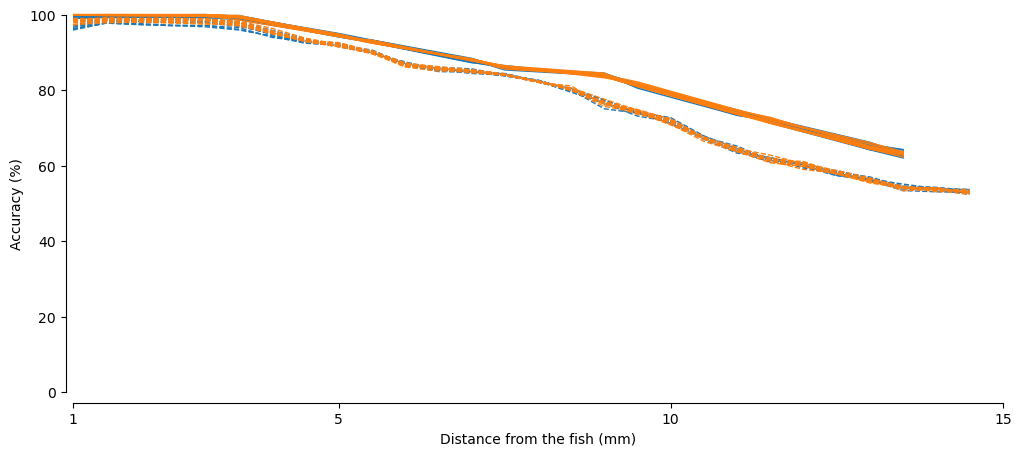

In [45]:
plt.figure(figsize=(12,5))
models.apply(plot_psychometric_curves, axis=1)
plt.ylim(-1,101)
plt.xlim(1,15)
plt.xticks([1, 5, 10, 15])
sns.despine(offset=5, trim=True)
plt.xlabel("Distance from the fish (mm)")
plt.ylabel("Accuracy (%)")
plt.show()

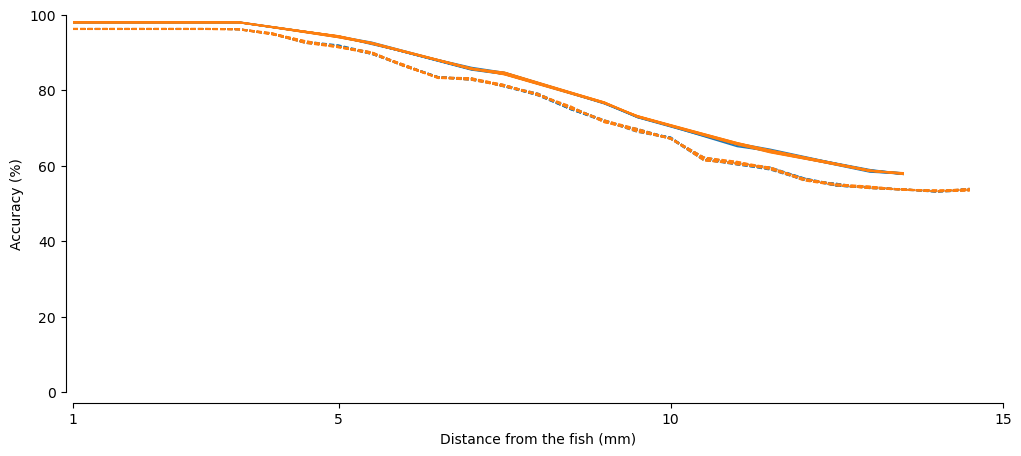

In [55]:
plt.figure(figsize=(12,5))
models.apply(plot_psychometric_curves, axis=1)
plt.ylim(-1,101)
plt.xlim(1,15)
plt.xticks([1, 5, 10, 15])
sns.despine(offset=5, trim=True)
plt.xlabel("Distance from the fish (mm)")
plt.ylabel("Accuracy (%)")
plt.show()